## Simulated Annealing Custom Plots

This notebook demonstrates a set of custom diagnostic plots for Simulated Annealing in PyPerch.

In [16]:
# =========================================================
# Setup cell – run once
# =========================================================

from __future__ import annotations

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

from pyperch import Perch
from pyperch.models import SimpleMLP
from pyperch.core.metrics import F1

# -------------------------
# Reproducibility
# -------------------------
BASE_SEED = 42
np.random.seed(BASE_SEED)
torch.manual_seed(BASE_SEED)

# -------------------------
# SA hyperparameters (for logging / plotting)
# -------------------------
SA_T0 = 2.0
SA_T_MIN = 0.001
SA_COOLING = 0.995

BATCH_SIZE = 64
VALID_SPLIT = 0.2

# -------------------------
# Dataset
# -------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=BASE_SEED,
)

X = X.astype(np.float32)
y = y.astype(np.int64)

# -------------------------
# Steps per epoch (train only)
# -------------------------
n_train = int(len(X) * (1 - VALID_SPLIT))
steps_per_epoch = int(np.ceil(n_train / BATCH_SIZE))

# -------------------------
# Perch builder
# -------------------------
perch = (
    Perch()
    .model(
        SimpleMLP,
        input_dim=12,
        hidden=[32],
        output_dim=2,
        activation="relu",
        loss_fn=nn.CrossEntropyLoss(),
    )
    .optimizer(
        "sa",
        t=SA_T0,
        t_min=SA_T_MIN,
        cooling=SA_COOLING,
        step_size=0.05,
    )
    .metrics(F1())
    .data(
        X,
        y,
        batch_size=BATCH_SIZE,
        valid_split=VALID_SPLIT,
        stratify=True,
        normalize=None,
    )
)

# -------------------------
# Multi-run training + temperature recording
# -------------------------
N_RUNS = 5
MAX_EPOCHS = 300

histories = []
temperatures = []

for i in range(N_RUNS):
    seed = BASE_SEED + i

    _, history = perch.train(
        max_epochs=MAX_EPOCHS,
        seed=seed,
        optimizer_mode="per_batch",
    )

    # --- Record SA temperature per epoch ---
    t = SA_T0
    temps = []

    for _ in history["epoch"]:
        temps.append(t)
        t = max(t * (SA_COOLING ** steps_per_epoch), SA_T_MIN)

    histories.append(history)
    temperatures.append(np.array(temps))

# -------------------------
# Stacking helpers
# -------------------------
def stack_histories(histories, key):
    return np.array([h[key] for h in histories if key in h])


def stack_metric(histories, split, name):
    """
    split: 'train_metrics' or 'valid_metrics'
    name: metric name, e.g. 'f1'
    """
    runs = []
    for h in histories:
        metrics = h.get(split, {})
        values = metrics.get(name)
        if values is not None:
            runs.append(values)
    return np.array(runs)


# -------------------------
# Stacked arrays (aligned by epoch)
# -------------------------
epochs = histories[0]["epoch"]

train_loss = stack_histories(histories, "train_loss")
valid_loss = stack_histories(histories, "valid_loss")

train_f1 = stack_metric(histories, "train_metrics", "f1")
valid_f1 = stack_metric(histories, "valid_metrics", "f1")

temperature = np.vstack(temperatures)

# -------------------------
# Sanity checks (optional)
# -------------------------
print("train_loss:", train_loss.shape)
print("valid_loss:", valid_loss.shape)
print("train_f1:", train_f1.shape)
print("valid_f1:", valid_f1.shape)
print("temperature:", temperature.shape)


train_loss: (5, 300)
valid_loss: (5, 300)
train_f1: (5, 300)
valid_f1: (5, 300)
temperature: (5, 300)


Mean + ±1 std band (loss)

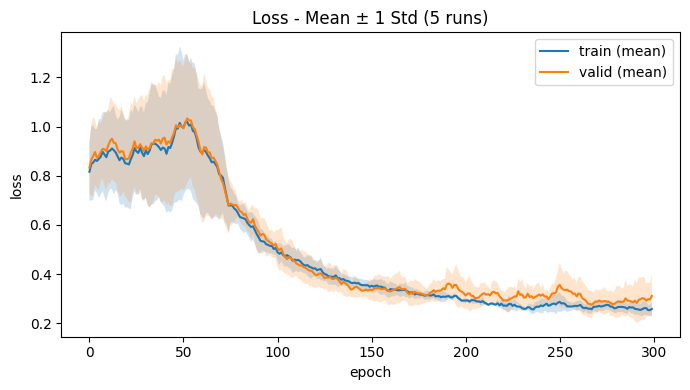

In [17]:
plt.figure(figsize=(7, 4))

# Train
train_mean = train_loss.mean(axis=0)
train_std = train_loss.std(axis=0)
plt.plot(epochs, train_mean, label="train (mean)")
plt.fill_between(
    epochs,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2,
)

# Validation
valid_mean = valid_loss.mean(axis=0)
valid_std = valid_loss.std(axis=0)
plt.plot(epochs, valid_mean, label="valid (mean)")
plt.fill_between(
    epochs,
    valid_mean - valid_std,
    valid_mean + valid_std,
    alpha=0.2,
)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss - Mean ± 1 Std (5 runs)")
plt.legend()
plt.tight_layout()
plt.show()

Min / max envelope (train + valid loss)

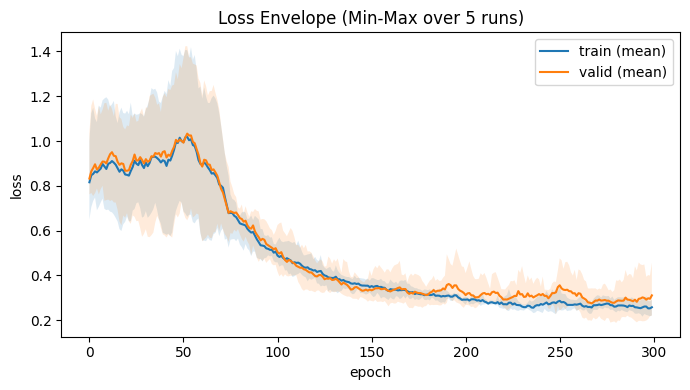

In [18]:
plt.figure(figsize=(7, 4))

# Train envelope
plt.plot(
    epochs,
    train_loss.mean(axis=0),
    label="train (mean)",
)
plt.fill_between(
    epochs,
    train_loss.min(axis=0),
    train_loss.max(axis=0),
    alpha=0.15,
)

# Validation envelope
plt.plot(
    epochs,
    valid_loss.mean(axis=0),
    label="valid (mean)",
)
plt.fill_between(
    epochs,
    valid_loss.min(axis=0),
    valid_loss.max(axis=0),
    alpha=0.15,
)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss Envelope (Min-Max over 5 runs)")
plt.legend()
plt.tight_layout()
plt.show()

Final epoch distribution (train + valid loss)

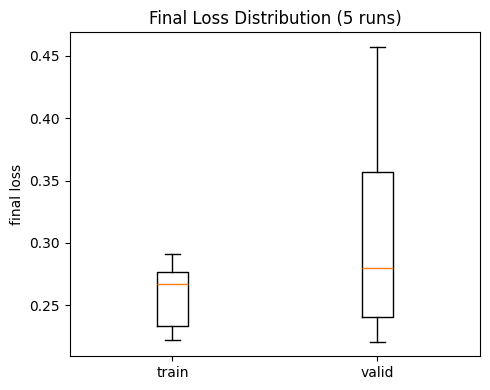

In [19]:
train_final = train_loss[:, -1]
valid_final = valid_loss[:, -1]

plt.figure(figsize=(5, 4))
plt.boxplot(
    [train_final, valid_final],
    labels=["train", "valid"],
)
plt.ylabel("final loss")
plt.title("Final Loss Distribution (5 runs)")
plt.tight_layout()
plt.show()

Best-so-far curves (train + valid)

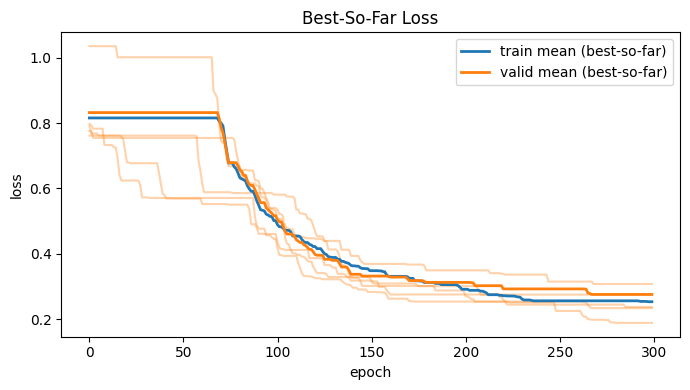

In [20]:
def best_so_far(x):
    return np.minimum.accumulate(x)

plt.figure(figsize=(7, 4))

# Individual runs (validation)
for i in range(valid_loss.shape[0]):
    plt.plot(
        epochs,
        best_so_far(valid_loss[i]),
        alpha=0.35,
        color="tab:orange",
    )

# Mean best-so-far (train + valid)
plt.plot(
    epochs,
    best_so_far(train_loss.mean(axis=0)),
    color="tab:blue",
    linewidth=2,
    label="train mean (best-so-far)",
)
plt.plot(
    epochs,
    best_so_far(valid_loss.mean(axis=0)),
    color="tab:orange",
    linewidth=2,
    label="valid mean (best-so-far)",
)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Best-So-Far Loss")
plt.legend()
plt.tight_layout()
plt.show()

Final metric distribution (train + valid F1)

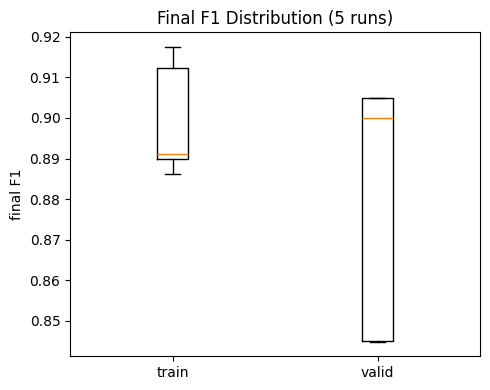

In [21]:
train_f1_final = train_f1[:, -1]
valid_f1_final = valid_f1[:, -1]

plt.figure(figsize=(5, 4))
plt.boxplot(
    [train_f1_final, valid_f1_final],
    labels=["train", "valid"],
)
plt.ylabel("final F1")
plt.title("Final F1 Distribution (5 runs)")
plt.tight_layout()
plt.show()

SA Loss Trajectory Scatter

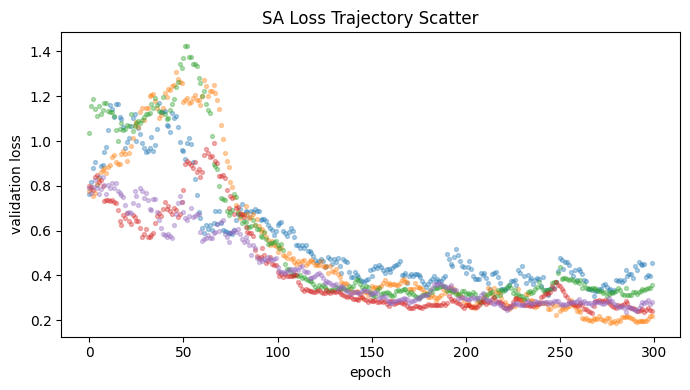

In [23]:
plt.figure(figsize=(7, 4))

for i in range(valid_loss.shape[0]):
    plt.scatter(
        epochs,
        valid_loss[i],
        s=8,
        alpha=0.35,
    )

plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.title("SA Loss Trajectory Scatter")
plt.tight_layout()
plt.show()

Temp. vs loss plot

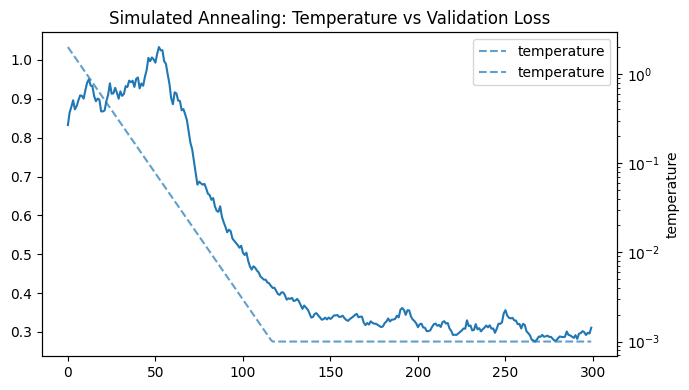

In [25]:
plt.figure(figsize=(7, 4))

# Mean validation loss over runs
plt.plot(
    epochs,
    valid_loss.mean(axis=0),
    label="valid loss (mean)",
)

# Mean temperature over runs
ax = plt.gca().twinx()
ax.plot(
    epochs,
    temperature.mean(axis=0),
    linestyle="--",
    alpha=0.7,
    label="temperature",
)
ax.set_yscale("log")
ax.set_ylabel("temperature")

plt.xlabel("epoch")
plt.title("Simulated Annealing: Temperature vs Validation Loss")

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2)

plt.tight_layout()
plt.show()
